### This code illustrates the learning algorithm for Dense Associative Memories from [Dense Associative Memory for Pattern Recognition](https://arxiv.org/abs/1606.01164) on MNIST data set.
If you want to learn more about Dense Associative Memories, check out a [NIPS 2016 talk](https://channel9.msdn.com/Events/Neural-Information-Processing-Systems-Conference/Neural-Information-Processing-Systems-Conference-NIPS-2016/Dense-Associative-Memory-for-Pattern-Recognition) or a [research seminar](https://www.youtube.com/watch?v=lvuAU_3t134). 

This cell loads the data and normalizes it to the [-1,1] range

In [32]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
!pip install emnist
from emnist import extract_training_samples, extract_test_samples

You should consider upgrading via the 'c:\python39\python.exe -m pip install --upgrade pip' command.


In [33]:
images, labels = extract_training_samples('letters')
images_test, labels_test = extract_test_samples('letters')

chars = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
chars_idx = []

for char in chars:
    char_num = ord(char) - 96
    chars_idx.append(char_num)

def get_indices_per_char(is_train, chars_str):
    indices_per_char_test = []

    for char_str in chars_str:
        char_num = ord(char_str) - 96
        c_labels = labels if is_train else labels_test
        char_indices = [i for i, x in enumerate(c_labels) if x == char_num]
        indices_per_char_test.append(char_indices)
    return indices_per_char_test

indices_per_char = get_indices_per_char(True, chars)
indices_per_char_test = get_indices_per_char(False, chars)

N=784                                  # total neurons
Nc=len(chars)                 # classifier neurons
training_size=4800*len(chars)
test_size=800*len(chars)

M=np.zeros((0,N))
Lab=np.zeros((Nc,0))
for i in range(Nc):
    flat_images = images[indices_per_char[i]].reshape((4800, 784))
    M=np.concatenate((M, flat_images), axis=0)
    lab1=-np.ones((Nc,4800))
    lab1[i,:]=1.0
    Lab=np.concatenate((Lab,lab1), axis=1)
M=2*M/255.0-1
M=M.T

MT=np.zeros((0,N))
LabT=np.zeros((Nc,0))
for i in range(Nc):
    flat_images = images_test[indices_per_char_test[i]].reshape((800, 784))
    MT=np.concatenate((MT, flat_images), axis=0)
    lab1=-np.ones((Nc,800))
    lab1[i,:]=1.0
    LabT=np.concatenate((LabT,lab1), axis=1)
MT=2*MT/255.0-1
MT=MT.T

# print(indices_per_char_test[0][2])
# plt.imshow(np.reshape(MT[:,800], (28,28)))
# plt.show()

26


In [44]:
import scipy.io
mat = scipy.io.loadmat('mnist_all.mat')
print("hello")
print(mat['train'+str(i)].shape)

hello
(5958, 784)


To draw a heatmap of the weights together with the errors on the training set (blue) and the test set (red) a helper function is created:

In [4]:
def draw_weights(synapses, Kx, Ky, err_tr, err_test):
    fig.clf()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    plt.sca(ax1)
    yy=0
    HM=np.zeros((28*Kx,28*Ky))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:].reshape(28,28)
            yy += 1
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
    cbar=fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    plt.axis('off')
    cbar.ax.tick_params(labelsize=30) 
    
    plt.sca(ax2)
    plt.ylim((0,100))
    plt.xlim((0,len(err_tr)+1))
    ax2.plot(np.arange(1, len(err_tr)+1, 1), err_tr, color='b', linewidth=4)
    ax2.plot(np.arange(1, len(err_test)+1, 1), err_test, color='r',linewidth=4)
    ax2.set_xlabel('Number of epochs', size=30)
    ax2.set_ylabel('Training and test error, %', size=30)
    ax2.tick_params(labelsize=30)

    plt.tight_layout()
    fig.canvas.draw()

This cell defines parameters of the algorithm: `n` - power of the rectified polynomial in [Eq 3](https://arxiv.org/abs/1606.01164); `m` - power of the loss function in [Eq 14](https://arxiv.org/abs/1606.01164); `K` - number of memories that are displayed as an `Ky` by `Kx` array by the helper function defined above; `eps0` - initial learning rate that is exponentially annealed during training with the damping parameter `f`, as explained in [Eq 12](https://arxiv.org/abs/1606.01164); `p` - momentum as defined in [Eq 13](https://arxiv.org/abs/1606.01164); `mu` - the mean of the gaussian distribution that initializes the weights; `sigma` - the standard deviation of that gaussian; `Nep` - number of epochs; `Num` - size of the training minibatch; `NumT` - size of the test minibatch; `prec` - parameter that controls numerical precision of the weight updates. Parameter `beta` that is used in [Eq 9](https://arxiv.org/abs/1606.01164) is defined as `beta=1/Temp**n`. The choice of temperatures `Temp` as well as the duration of the annealing `thresh_pret` is discussed in [Appendix A](https://arxiv.org/abs/1606.01164). 

In [40]:
Kx=23              # Number of memories per row on the weights plot
Ky=23              # Number of memories per column on the weigths plot
K=Kx*Ky            # Number of memories
n=20               # Power of the interaction vertex in the DAM energy function
m=30               # Power of the loss function
eps0=4.0e-2        # Initial learning rate  
f=0.998            # Damping parameter for the learning rate
p=0.6                         # Momentum
epochs=300                    # Number of epochs
Temp_in=540.                  # Initial temperature
Temp_f=540.                   # Final temperature
thresh_pret=200               # Length of the temperature ramp
training_batch_size=600       # Size of training minibatch     
test_batch_size=1200          # Size of test minibatch 
mu=-0.3            # Weights initialization mean
sigma=0.3          # Weights initialization std
prec=1.0e-30       # Precision of weight update
has_starting_memories = True
n_starting_memories = 26*15

This cell defines the main code. The external loop runs over epochs `nep`, the internal loop runs over minibatches.  The weights are updated after each minibatch in a way so that the largest update is equal to the learning rate `eps` at that epoch, see [Eq 13](https://arxiv.org/abs/1606.01164). The weights are displayed by the helper function after each epoch. 

<IPython.core.display.Javascript object>


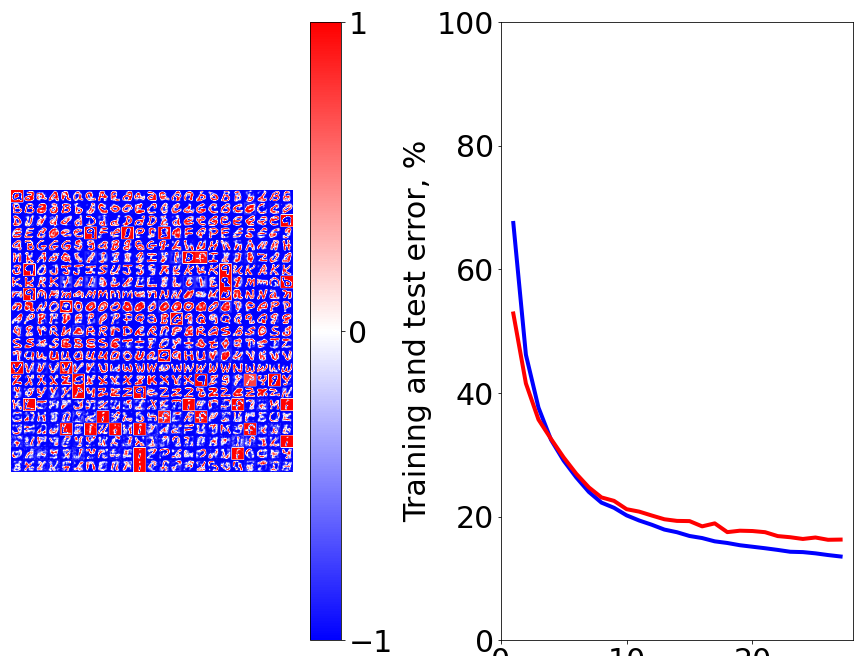

C:\Users\meesg\AppData\Local\Temp/ipykernel_19640/1747218626.py:8: DeprecationWarning: This function is deprecated. Please call randint(0, 4800 + 1) instead
  char_image_idxs = np.random.random_integers(0, len(indices_per_char[char_counter]), n_starting_memories // len(chars))


here
[ 0  0 11 ...  7  2 19]
[0 0 0 ... 1 1 1]
452
[ 1  7  1 ... 11  2  2]
[1 1 1 ... 2 2 2]
1100
[11  3  2 ...  2  2  4]
[3 3 3 ... 4 4 4]
1553
[14  2  2 ...  6 15  5]
[4 4 4 ... 5 5 5]
1863
[ 9 14  6 ...  9  7 11]
[6 6 6 ... 7 7 7]
2258
[3 7 7 ... 8 8 8]
[7 7 7 ... 8 8 8]
2982
[ 8  9 18 ... 11  2 11]
[ 9  9  9 ... 10 10 10]
3522
[10  1  5 ... 11 11 25]
[10 10 10 ... 11 11 11]
3950
[12 12 12 ... 13 15 13]
[12 12 12 ... 13 13 13]
4839
[13 13 13 ...  9  6 14]
[13 13 13 ... 14 14 14]
5577
[15 11 15 ... 19  8 15]
[15 15 15 ... 16 16 16]
6196
[20 20 22 ... 12 10  2]
[16 16 16 ... 17 17 17]
6522
[ 2 18  9 ... 19 17 11]
[18 18 18 ... 19 19 19]
7103
[ 8  8 21 ... 20 20 20]
[19 19 19 ... 20 20 20]
7665
[ 9 24 20 ... 22 22 22]
[21 21 21 ... 22 22 22]
8512
[22 22 22 ... 21 23  2]
[22 22 22 ... 23 23 23]
9220
[ 9 21 23 ... 25 25  9]
[24 24 24 ... 25 25 25]
9802
[0 0 2 ... 1 1 5]
[0 0 0 ... 1 1 1]
628
[1 3 1 ... 2 2 2]
[1 1 1 ... 2 2 2]
1371
[19  3  1 ...  4  4  2]
[3 3 3 ... 4 4 4]
2038
[ 4  4  2

[18 18 18 ... 19 19 19]
[18 18 18 ... 19 19 19]
12288
[19 19 19 ... 20 20 20]
[19 19 19 ... 20 20 20]
13316
[21 21 21 ... 22 22 22]
[21 21 21 ... 22 22 22]
14379
[22 22 22 ... 23 23 23]
[22 22 22 ... 23 23 23]
15387
[ 6 24 24 ... 25 25  9]
[24 24 24 ... 25 25 25]
16390
[0 0 0 ... 1 1 1]
[0 0 0 ... 1 1 1]
914
[1 1 1 ... 2 2 4]
[1 1 1 ... 2 2 2]
1945
[5 3 1 ... 4 4 4]
[3 3 3 ... 4 4 4]
2849
[ 4  4  4 ...  5 17  5]
[4 4 4 ... 5 5 5]
3853
[6 6 6 ... 7 7 7]
[6 6 6 ... 7 7 7]
4639
[7 7 7 ... 8 8 8]
[7 7 7 ... 8 8 8]
5442
[ 8  9  9 ... 10 10 10]
[ 9  9  9 ... 10 10 10]
6411
[10 10 10 ... 11 11 11]
[10 10 10 ... 11 11 11]
7376
[12 12 12 ... 13  7 13]
[12 12 12 ... 13 13 13]
8411
[13 13 13 ... 14 14 14]
[13 13 13 ... 14 14 14]
9406
[15 15 15 ...  4  5 19]
[15 15 15 ... 16 16 16]
10356
[16 16 16 ... 22 17 17]
[16 16 16 ... 17 17 17]
11229
[18 18 18 ... 19 19 19]
[18 18 18 ... 19 19 19]
12309
[19 19 19 ... 20 20 20]
[19 19 19 ... 20 20 20]
13376
[21 21 21 ... 22 22 22]
[21 21 21 ... 22 22 22]
143

[10 10 10 ... 11  8 11]
[10 10 10 ... 11 11 11]
7712
[12 12 12 ... 13 15 13]
[12 12 12 ... 13 13 13]
8789
[13 13 13 ... 14 14 14]
[13 13 13 ... 14 14 14]
9871
[15 15  5 ... 19  5 16]
[15 15 15 ... 16 16 16]
10884
[16 16 16 ... 12 17 17]
[16 16 16 ... 17 17 17]
11839
[18 18 18 ... 19 19 19]
[18 18 18 ... 19 19 19]
12890
[19 19 19 ... 20 20 20]
[19 19 19 ... 20 20 20]
13954
[20 21 21 ... 22 22 22]
[21 21 21 ... 22 22 22]
15012
[22 22 22 ... 23 23 23]
[22 22 22 ... 23 23 23]
16054
[ 6 24 24 ... 25 25  8]
[24 24 24 ... 25 25 25]
17125
[0 0 0 ... 1 1 1]
[0 0 0 ... 1 1 1]
990
[1 1 1 ... 2 2 4]
[1 1 1 ... 2 2 2]
2043
[10  3  1 ...  4  4  4]
[3 3 3 ... 4 4 4]
2979
[4 4 4 ... 5 5 5]
[4 4 4 ... 5 5 5]
4027
[ 6  6  6 ... 20  7  7]
[6 6 6 ... 7 7 7]
4840
[7 7 7 ... 8 8 8]
[7 7 7 ... 8 8 8]
5684
[ 8  9  9 ... 10 10 10]
[ 9  9  9 ... 10 10 10]
6726
[10 10 10 ... 11 11 11]
[10 10 10 ... 11 11 11]
7653
[12 12 12 ... 13 15 13]
[12 12 12 ... 13 13 13]
8727
[13 13 13 ... 14 14 14]
[13 13 13 ... 14 14 14]

In [ ]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,10))

memories=np.random.normal(mu, sigma, (K, N+Nc)) # random starting memories
if has_starting_memories:
    for char_counter, char_idx in enumerate(chars_idx):
        char_image_idxs = np.random.random_integers(0, len(indices_per_char[char_counter]), n_starting_memories // len(chars))
        image_idxs = np.array(indices_per_char[char_counter])[char_image_idxs]
        for image_counter, image_idx in enumerate(image_idxs):
            image_data = images[image_idx].flatten()
            classifier_data = -np.ones((Nc,))
            classifier_data[char_counter] = 1
            memory = np.concatenate((image_data, classifier_data))
            memories[char_counter * (n_starting_memories // len(chars)) + image_counter] = memory
VKS=np.zeros((K, N+Nc))

# plt.imshow(np.reshape(memories[50][0:784], (28, 28)))
# print(memories[50][784:784+Nc])
print("here")

aux=-np.ones((Nc,training_batch_size*Nc))
for d in range(Nc):
    aux[d,d*training_batch_size:(d+1)*training_batch_size]=1.

auxT=-np.ones((Nc,test_batch_size*Nc))
for d in range(Nc):
    auxT[d,d*test_batch_size:(d+1)*test_batch_size]=1.
    
err_tr=[]
err_test=[]
for epoch in range(epochs):
    learning_rate=eps0*f**epoch
    # Temperature ramp
    if epoch<=thresh_pret:
        Temp=Temp_in+(Temp_f-Temp_in)*epoch/thresh_pret
    else:
        Temp=Temp_f
    beta=1./Temp**n

    # Training
    perm=np.random.permutation(training_size) # random order
    M=M[:,perm]                               # change memory order
    Lab=Lab[:,perm]                           # change label order
    num_correct = 0
    # for every batch
    for k in range(training_size//training_batch_size):       # floor division
        batch_memories = M[:,k*training_batch_size:(k+1)*training_batch_size] 
        batch_labels = Lab[:,k*training_batch_size:(k+1)*training_batch_size]
        t=np.reshape(batch_labels,(1,Nc*training_batch_size))
                
        # u = memories in column form with classifier neurons all -1
        u=np.concatenate((batch_memories, -np.ones((Nc,training_batch_size))),axis=0)
        # uu = Nc * every memory
        uu=np.tile(u,(1,Nc))
        
        # vv = memories in column form with classifier neurons with one +1
        vv=np.concatenate((uu[:N,:],aux),axis=0) 
                
        KSvv=np.maximum(np.dot(memories,vv),0)    # memories with positive classifier
        KSuu=np.maximum(np.dot(memories,uu),0)    # memories with negative classifier
        
        # Diff F(postive classifier) and F(negative classifier)
        Y=np.tanh(beta*np.sum(KSvv**n-KSuu**n, axis=0))  # Forward path, Eq 9
        pred_labels=np.reshape(Y,(Nc,training_batch_size))
        
        # Gradients of the loss function
        d_KS=np.dot(np.tile((t-Y)**(2*m-1)*(1-Y)*(1+Y), (K,1))*KSvv**(n-1),vv.T) - np.dot(np.tile((t-Y)**(2*m-1)*(1-Y)*(1+Y), (K,1))*KSuu**(n-1),uu.T)
        
        VKS=p*VKS+d_KS
        nc=np.amax(np.absolute(VKS),axis=1).reshape(K,1)
        nc[nc<prec]=prec
        ncc=np.tile(nc,(1,N+Nc))
        memories += learning_rate*VKS/ncc
        memories=np.clip(memories, a_min=-1., a_max=1.)
        
        correct=np.argmax(pred_labels,axis=0)==np.argmax(batch_labels,axis=0)
        num_correct += np.sum(correct)
        
    err_tr.append(100.*(1.0-num_correct/training_size))
    
    # Testing
    num_correct = 0
    for k in range(test_size//test_batch_size):
        v=MT[:,k*test_batch_size:(k+1)*test_batch_size]
        t_R=LabT[:,k*test_batch_size:(k+1)*test_batch_size]
        u=np.concatenate((v, -np.ones((Nc,test_batch_size))),axis=0)
        uu=np.tile(u,(1,Nc))
        vv=np.concatenate((uu[:N,:],auxT),axis=0)
        KSvv=np.maximum(np.dot(memories,vv),0)
        KSuu=np.maximum(np.dot(memories,uu),0)
        Y=np.tanh(beta*np.sum(KSvv**n-KSuu**n, axis=0))  # Forward path, Eq 9
        Y_R=np.reshape(Y,(Nc,test_batch_size))
        correct=np.argmax(Y_R,axis=0)==np.argmax(t_R,axis=0)
        num_correct += np.sum(correct)
        print(np.argmax(Y_R,axis=0))
        print(np.argmax(t_R,axis=0))
        print(num_correct)
    errr=100.*(1.0-num_correct/test_size)
    err_test.append(errr)
    draw_weights(memories[:,:N], Kx, Ky, err_tr, err_test)


In [ ]:
print("test")

In [20]:
print(memories[99])

[-0.99808864 -0.99808864 -0.99808864 -0.99808864 -0.99808864 -0.99808864
 -0.99808864 -0.99808864 -0.99808864 -0.99808864 -0.99808864 -0.99808864
 -0.99808864 -0.99808864 -0.99808864 -0.99809019 -0.99809435 -0.99809092
 -0.99808896 -0.99808864 -0.99808864 -0.99808864 -0.99808864 -0.99808864
 -0.99808864 -0.99808864 -0.59953436 -0.99808864 -0.99808864 -0.99808867
 -0.99808915 -0.99809024 -0.99809024 -0.99809075 -0.9980991  -0.99810482
 -0.9980989  -0.99809031 -0.99874241 -0.99911474 -0.99898927 -0.99909775
 -0.99859424 -0.99867068 -0.99853434 -0.99821596 -0.9982589  -0.99829012
 -0.99798663 -0.99807104 -0.99813322 -0.99811821 -0.99808825 -0.99808971
 -0.99808869 -0.99808864 -0.99808864 -0.99808895 -0.99810037 -0.99811203
 -0.99811686 -0.99815044 -0.99824902 -0.99822561 -0.998185   -0.99732403
 -0.99982936 -1.         -1.         -1.         -1.         -0.99969988
 -0.99977375 -0.99905727 -0.99792219 -0.99668059 -0.98930258 -0.99679088
 -0.99861021 -0.99865832 -0.99823852 -0.99811387 -0

In [30]:
from scipy.io import savemat

mdic = {"memories": memories, "label": "23l86c"}
savemat("matlab_matrix.mat", mdic)